## CARE projection training ##

Here is the notebook to train the CARE projection network able to project in 2D, 3D CARE restored stacks. Once trained, it will predict from 3D stacks restored by CARE restoration model a 2D projection of the stacks. The prediction step is done thanks to another notebook.

Firstly, we import all the functions we need. We will specify the GPU we wants to use in the last line. We have to check that the GPU is not already use to avoid memory issues.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, ProjectionCARE, ProjectionConfig

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

We define in the following cell the path to the NPZ files (see *Generation of NPZ files for CARE projection training* notebook) we will use for the training. The model we will generate will have the same name than the NPZ file. 

We load the data and split the data set into 2 sets: the training set and the validation set. The proportion of data belonging to the Validation set is define thanks to *validation_split*

In [3]:
BaseDir = '/run/media/sancere/DATA/Lucas_NextonCreated_npz/'
ModelName = 'MariaTraining_projection_40x_bin2_Rfp'

load_path = BaseDir + ModelName + '.npz'

(X,Y), (X_val,Y_val), axes = load_training_data(load_path, validation_split=0.1, verbose=True)
c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 15833
number of validation images:	 1759
image size (3D):		 (17, 128, 128)
axes:				 SZYXC
channels in / out:		 1 / 1


Plot some validation data patches (with raw image and corresponding groundtruth).

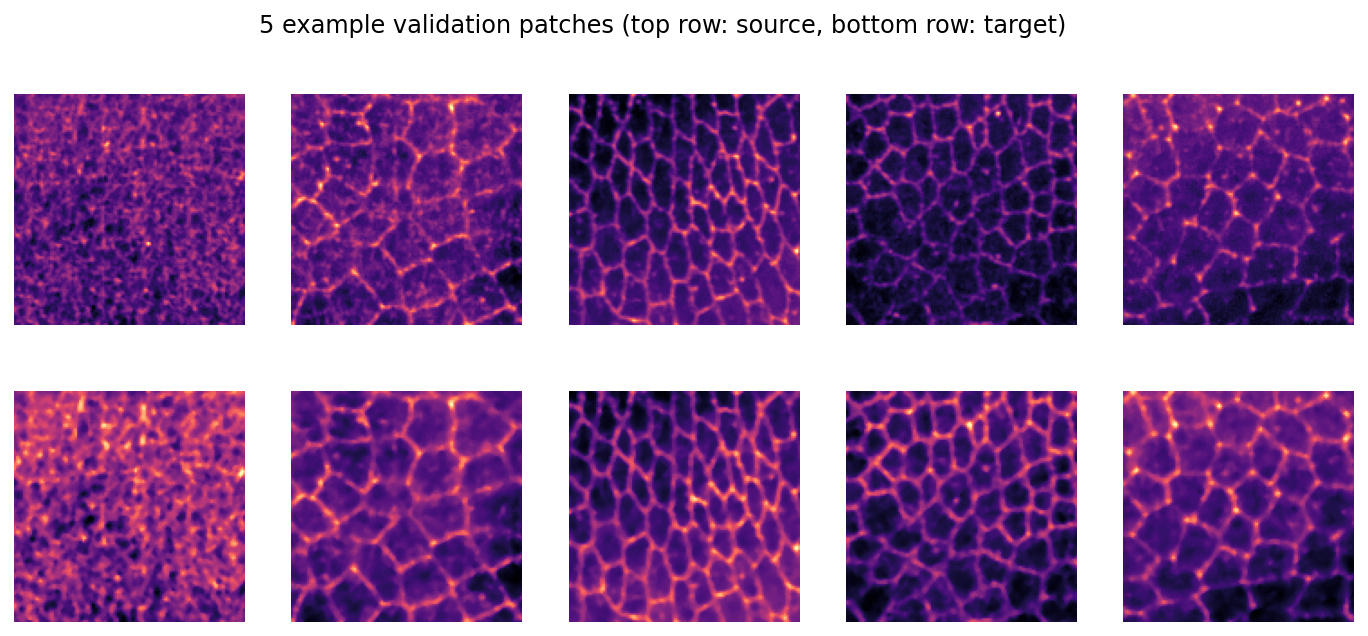

In [4]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

We define in the following cell the hyperparameters used for the training, number of epochs and number of steps per epochs. A config file recording all the parameters will be saved. 

In [5]:
config = ProjectionConfig(axes, n_channel_in, n_channel_out, unet_n_depth=4,train_epochs= 400,train_steps_per_epoch = 100, train_batch_size = 16, train_reduce_lr={'patience': 5, 'factor': 0.5})
print(config)
vars(config)

ProjectionConfig(axes='ZYXC', n_channel_in=1, n_channel_out=1, n_dim=3, probabilistic=False, proj_axis='Z', proj_kern=(3, 3, 3), proj_n_conv_per_depth=1, proj_n_depth=4, proj_n_filt=8, proj_pool=(1, 2, 2), train_batch_size=100, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=1, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'patience': 5, 'factor': 0.5}, train_steps_per_epoch=100, train_tensorboard=True, unet_input_shape=(None, None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=4, unet_n_first=32, unet_residual=True)


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 4,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 1,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0004,
 'train_batch_size': 100,
 'train_tensorboard': True,
 'train_reduce_lr': {'patience': 5, 'factor': 0.5},
 'proj_axis': 'Z',
 'proj_n_depth': 4,
 'proj_n_filt': 8,
 'proj_n_conv_per_depth': 1,
 'proj_kern': (3, 3, 3),
 'proj_pool': (1, 2, 2)}

Here we give to the model the hyperparameters, the name and the path where it will be saved.

**Primal:** `model.load_weights` allows to perform transfer learning, loading the h5 file from the given location.  

In [6]:
model = ProjectionCARE(config=config, name = ModelName, basedir = BaseDir)
#model.load_weights(BaseDir + ModelName + '/' + 'weights_best.h5')

/home/sancere/anaconda3/envs/tensorflowGPU/lib/python3.6/site-packages/csbdeep/models/base_model.py:148: UserWarning: output path for model already exists, files may be overwritten: /run/media/sancere/DATA/Lucas_NextonCreated_npz/MariaTraining_projection_40x_bin2_Rfp
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In the next cell, we launch the training. 

In [7]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

100/100 [==============================] - 107s 1s/step - loss: 0.0503 - mse: 0.0048 - mae: 0.0503 - val_loss: 0.0389 - val_mse: 0.0032 - val_mae: 0.0389 - lr: 4.0000e-04

Loading network weights from 'weights_best.h5'.


Then, we plot the loss curve of the training set and of the validation set to check that the training went well. (We can check if the training is finished, if there is overfitting etc - see https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


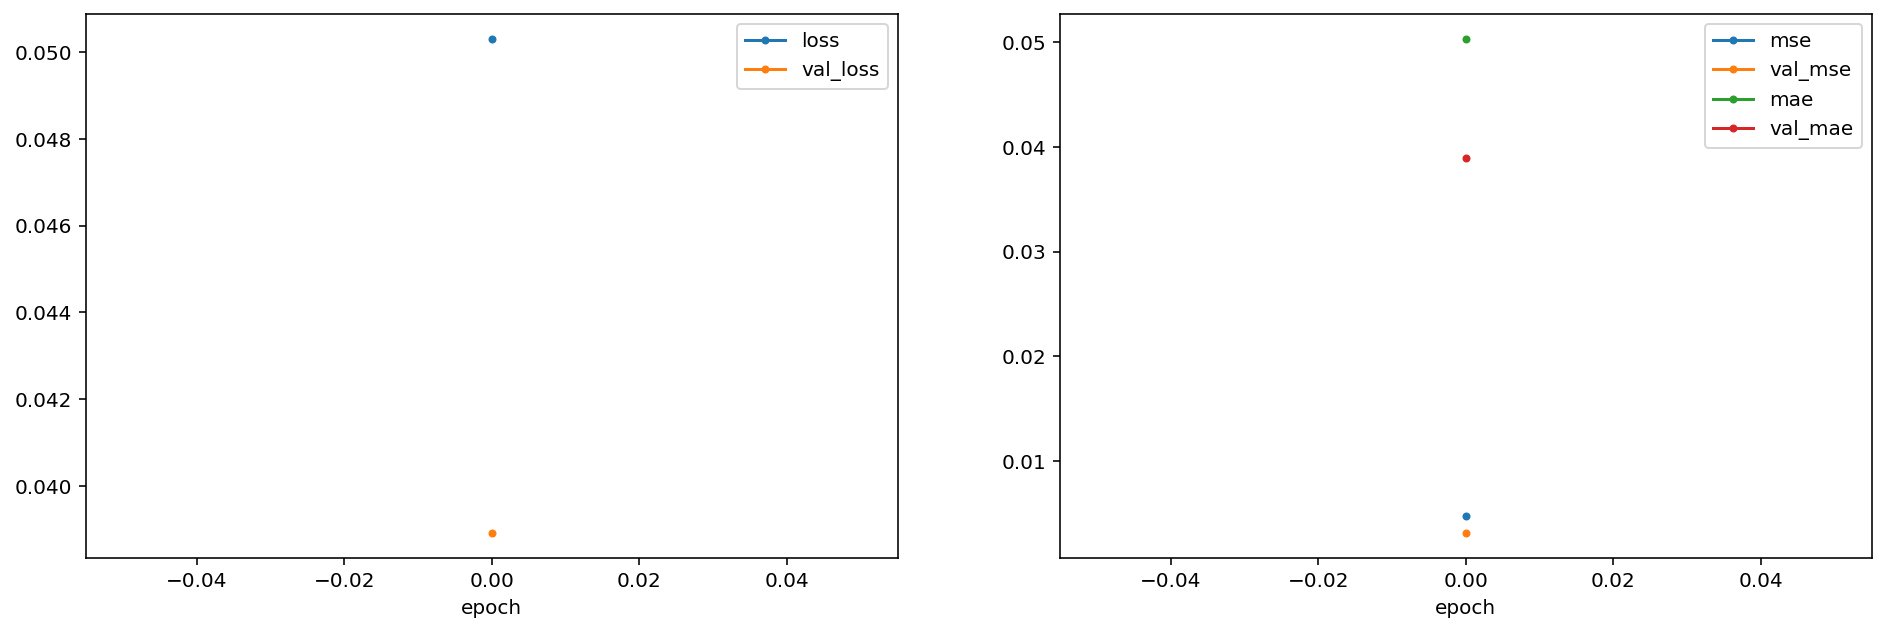

In [8]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

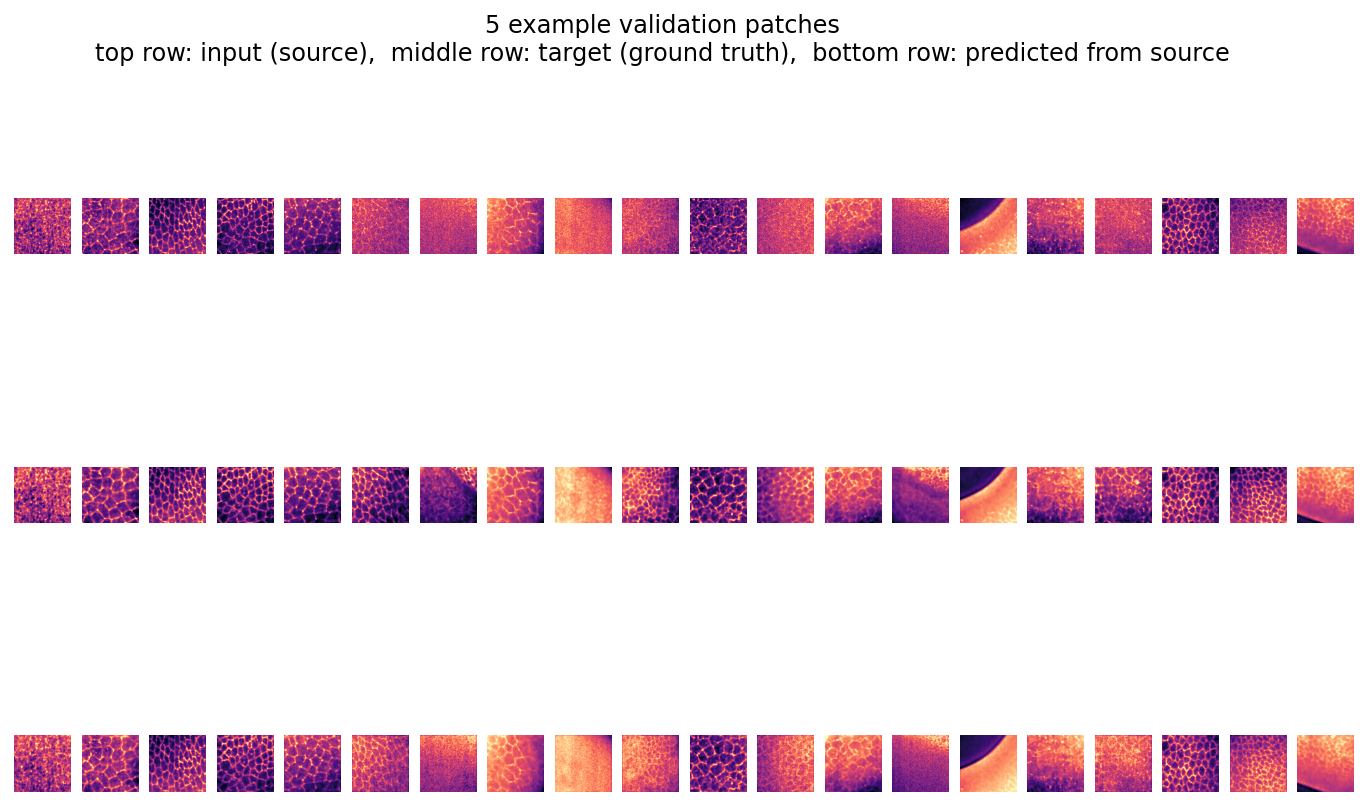

In [9]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:20])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:20],Y_val[:20],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

We then save the calculated weights.

In [10]:
model.export_TF()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmpgc10hba2/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/run/media/sancere/DATA/Lucas_NextonCreated_npz/MariaTraining_projection_40x_bin2_Rfp/TF_SavedModel.zip
